In [31]:
import astropy.constants as const
import astropy.units as u

import pandas as pd
import h5py
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from scipy.optimize import curve_fit

from lmfit import Parameters

import torch
import torch.nn.functional as F

# PlasmaPy packages you might need
from plasmapy.diagnostics import thomson
from plasmapy.diagnostics import cpu_autodiff_thomson

from mpl_toolkits.mplot3d import Axes3D

In [32]:
#################

filename_0 = "prts_1400000.h5"

with h5py.File(filename_0, "r") as hf3:
    xb = hf3['xb'][()]
    npatch = hf3['n_patch'][:]

filename_1 = "smaller_prts.h5"

with h5py.File(filename_1, "r") as hf3:
    uz = hf3['uz'][()]
    zz = hf3['z'][()]
    kind = hf3['kind'][()]

In [33]:
def index_count(nptch):
    inx_start = np.zeros(len(nptch))
    inx_end = np.zeros(len(nptch))
    for i in range(len(nptch)):
        inx_start[i] = np.sum(nptch[0:i])
        inx_end[i] = inx_start[i]+nptch[i]-1
    inx_start = inx_start.astype(int)
    inx_end = inx_end.astype(int)
    return inx_start, inx_end

def decimate_npatch(nptch):
    start, end = index_count(nptch)
    deci_patch = np.zeros(len(start))
    for i in range(len(start)):
        deci_patch[i] = math.floor(0.1*end[i])-math.floor(0.1*start[i])
        if start[i]%10 == 0:
            deci_patch[i] = deci_patch[i]+1
    deci_patch = deci_patch.astype(int)
    return deci_patch

deci_npatch = decimate_npatch(npatch[8500:])
print("shape of new npatch array:", np.shape(deci_npatch))
print("sum of deci_npatch:", np.sum(deci_npatch))
print("number of particles in zz array:", len(zz))

shape of new npatch array: (8500,)
sum of deci_npatch: 66168482
number of particles in zz array: 66168482


In [34]:

def fix_zz(nptch,zz_input,xb_input):
    zz_fixed=[]
    p1 = 0
    for i in range(8500):
        delta = nptch[i] # delta is the number of particles in a patch.
        p2 = p1 + delta  # Here we keep track of the total number of particles, the nth patch lies between the start of the patch p1 and p1+delta
        zz_patch = zz_input[p1:p2, 0].tolist() # we extract only the particles in the patch and put them in a list
        zz_patch_fix = [x+xb_input[8500+i,2] for x in zz_patch] # we then add the position of the patch xb to the relative position of the particles zz to get the absolut position of the particles in this patch
        zz_fixed.extend(zz_patch_fix) # we put the absolute positions of each particle into the new list
        print("npatch index:", i, end='\r')
        p1 = p2
    z_fixed = np.array(zz_fixed)
    return z_fixed
zz_fixed = fix_zz(deci_npatch,zz,xb)


In [35]:

def phasespacehistogram(u_input,z_fixed,kind_input,species=2,BINS=1700,RANGE=[[-0.25, 0.25], [0, 81600]]):
    ls = np.where(kind_input == species)[0] #extract an array of one species from total array of particles
    uz_spec = u_input[ls] 
    zz_spec = z_fixed[ls]
    dummy1 = np.transpose(uz_spec)[0] #for some reason, uz seems to be a column instead of a row. This fixes that
    dummy2 = zz_spec
    histogram = np.histogram2d(dummy1, dummy2, BINS, RANGE)[0] #we input out species-specific data into the histogram
    return histogram

phasehistogram_0 = phasespacehistogram(uz,zz_fixed,kind,0,RANGE=[[-1, 1], [0, 81600]])
phasehistogram_1 = phasespacehistogram(uz,zz_fixed,kind,1,RANGE=[[-1, 1], [0, 81600]])
# Adjust the number of variables to match the function's return values
phasehistogram_2 = phasespacehistogram(uz, zz_fixed, kind, 2, RANGE=[[-0.6, 0.6], [0, 81600]])
phasehistogram_3 = phasespacehistogram(uz,zz_fixed,kind,3, RANGE=[[-0.6, 0.6], [0, 81600]])

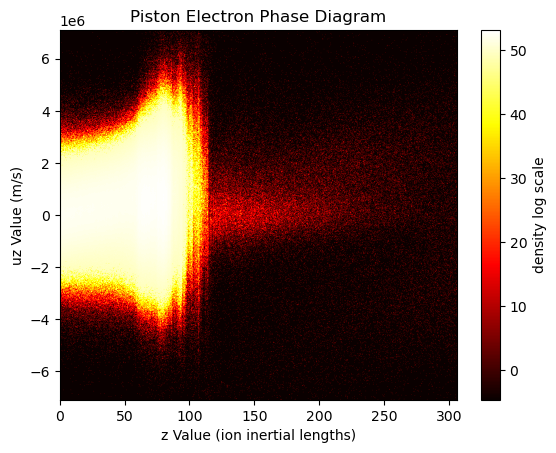

In [36]:
# Scale factors
x_scale = 0.3 / 10 / 8
y_scale = 7.1e6
density_scale = 6e20

# Apply scaling to the histogram data
scaled_histogram0 = phasehistogram_0 * density_scale

# Apply scaling to the x-axis and y-axis values
x_extent = (0, 81600 * x_scale)
y_extent = (-1 * y_scale, 1 * y_scale)

plt.figure(0)
plt.imshow(np.log(scaled_histogram0 + 0.01), cmap='hot', aspect='auto', origin='lower', extent=x_extent + y_extent)
# Add color bar
plt.colorbar(label='density log scale')

# Add labels and title
plt.xlabel('z Value (ion inertial lengths)')
plt.ylabel('uz Value (m/s)')
plt.title('Piston Electron Phase Diagram')

plt.show()

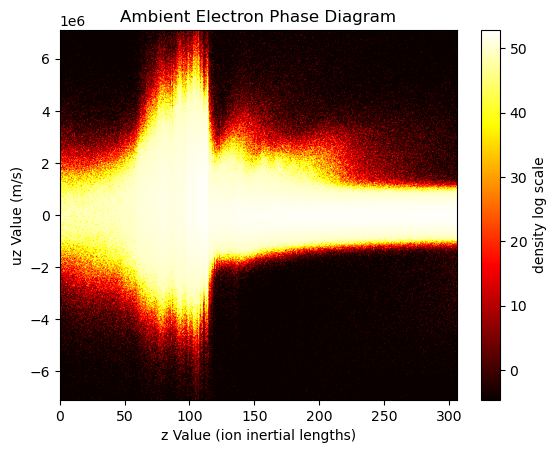

In [37]:
# Apply scaling to the histogram data
scaled_histogram1 = phasehistogram_1 * density_scale

# Apply scaling to the x-axis and y-axis values
x_extent1 = (0, 81600 * x_scale)
y_extent1 = (-1 * y_scale, 1 * y_scale)

plt.figure(1)
plt.imshow(np.log(scaled_histogram1 + 0.01), cmap='hot', aspect='auto', origin='lower', extent=x_extent1 + y_extent1)
# Add color bar
plt.colorbar(label='density log scale')

# Add labels and title
plt.xlabel('z Value (ion inertial lengths)')
plt.ylabel('uz Value (m/s)')
plt.title('Ambient Electron Phase Diagram')

plt.show()



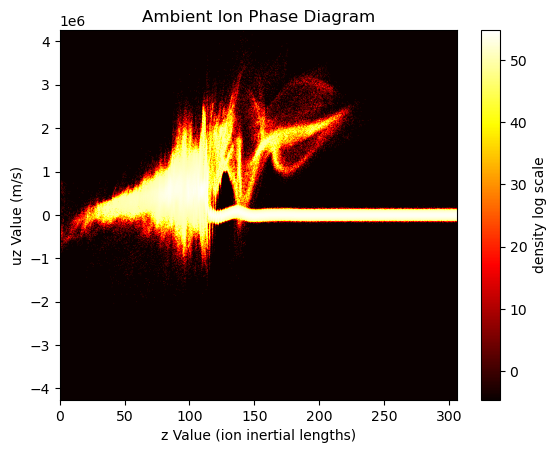

In [38]:
# Apply scaling to the histogram data
scaled_histogram2 = phasehistogram_2 * density_scale

# Apply scaling to the x-axis and y-axis values
x_extent2 = (0, 81600 * x_scale)
y_extent2 = (-0.6 * y_scale, 0.6 * y_scale)

plt.figure(2)
plt.imshow(np.log(scaled_histogram2 + 0.01), cmap='hot', aspect='auto', origin='lower', extent=x_extent2 + y_extent2)
# Add color bar
plt.colorbar(label='density log scale')

# Add labels and title
plt.xlabel('z Value (ion inertial lengths)')
plt.ylabel('uz Value (m/s)')
plt.title('Ambient Ion Phase Diagram')

plt.show()



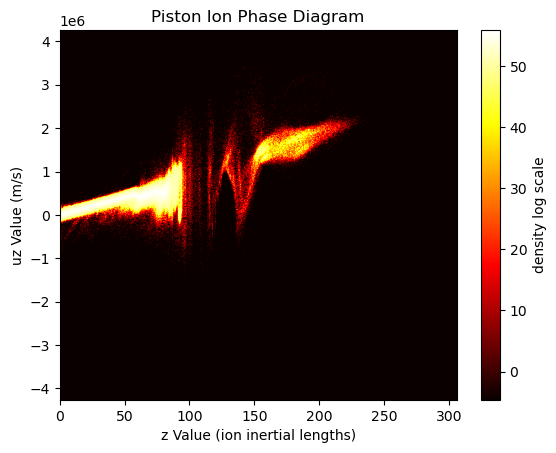

In [39]:
# Apply scaling to the histogram data
scaled_histogram3 = phasehistogram_3 * density_scale

# Apply scaling to the x-axis and y-axis values
x_extent3 = (0, 81600 * x_scale)
y_extent3 = (-0.6 * y_scale, 0.6 * y_scale)

plt.figure(3)
plt.imshow(np.log(scaled_histogram3 + 0.01), cmap='hot', aspect='auto', origin='lower', extent=x_extent3 + y_extent3)
# Add color bar
plt.colorbar(label='density log scale')

# Add labels and title
plt.xlabel('z Value (ion inertial lengths)')
plt.ylabel('uz Value (m/s)')
plt.title('Piston Ion Phase Diagram')

plt.show()


In [40]:
#get arrays
#get lists that correspond to a species
ls_0 = np.where(kind == 0)[0]
ls_1 = np.where(kind == 1)[0]
ls_2 = np.where(kind == 2)[0]
ls_3 = np.where(kind == 3)[0]

#get position array
zz_0 = zz_fixed[ls_0]
zz_1 = zz_fixed[ls_1]
zz_2 = zz_fixed[ls_2]
zz_3 = zz_fixed[ls_3]

#get velocity array
uz_0 = np.transpose(uz[ls_0])[0]
uz_1 = np.transpose(uz[ls_1])[0]
uz_2 = np.transpose(uz[ls_2])[0]
uz_3 = np.transpose(uz[ls_3])[0]

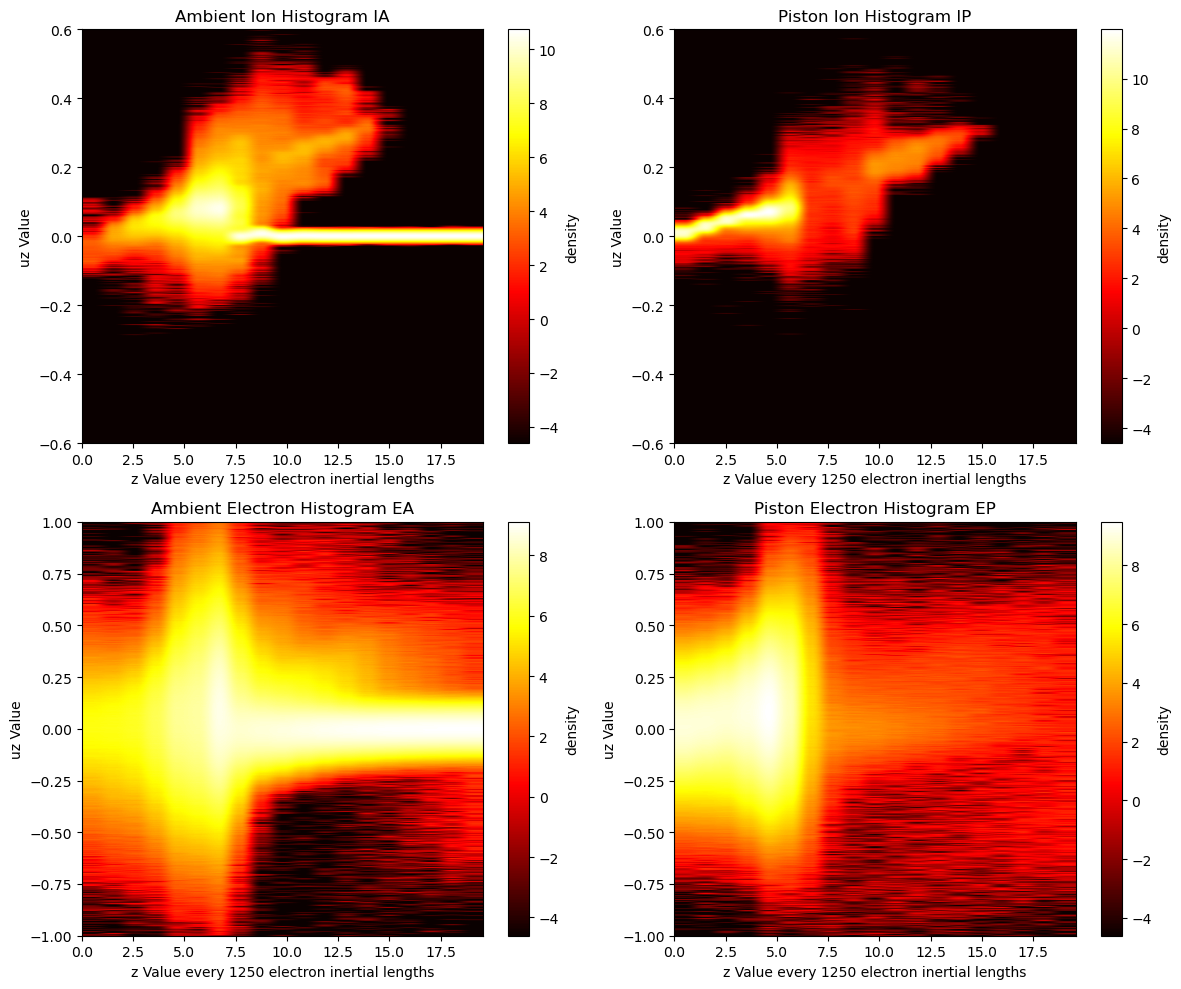

(1700, 19)
(1700, 19)
(1700, 19)
(1700, 19)


In [41]:
# Calculate 2D histograms
histogram_ia, xedges_ia, yedges_ia = np.histogram2d(uz_2, zz_2, bins=[1700, int(81600*0.3/50/25)], range=[[-0.6,0.6],[0,81600]])
histogram_ip, xedges_ip, yedges_ip = np.histogram2d(uz_3, zz_3, bins=[1700, int(81600*0.3/50/25)], range=[[-0.6,0.6],[0,81600]])
histogram_ea, xedges_ea, yedges_ea = np.histogram2d(uz_1, zz_1, bins=[1700, int(81600*0.3/50/25)], range=[[-1,1],[0,81600]])
histogram_ep, xedges_ep, yedges_ep = np.histogram2d(uz_0, zz_0, bins=[1700, int(81600*0.3/50/25)], range=[[-1,1],[0,81600]])

# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot each 2D histogram in a subplot
cmap = 'hot'
extent1 = [0, 81600*0.3/50/25, -0.6, 0.6]
extent2 = [0, 81600*0.3/50/25, -1, 1]

# Ambient ion histogram
im1 = axs[0, 0].imshow(np.log(histogram_ia + 0.01), origin='lower', extent=extent1, aspect='auto', cmap=cmap)
axs[0, 0].set_xlabel('z Value every 1250 electron inertial lengths')
axs[0, 0].set_ylabel('uz Value')
axs[0, 0].set_title('Ambient Ion Histogram IA')
plt.colorbar(im1, ax=axs[0, 0], label='density')

# Ambient ion histogram
im2 = axs[0, 1].imshow(np.log(histogram_ip + 0.01), origin='lower', extent=extent1, aspect='auto', cmap=cmap)
axs[0, 1].set_xlabel('z Value every 1250 electron inertial lengths')
axs[0, 1].set_ylabel('uz Value')
axs[0, 1].set_title('Piston Ion Histogram IP')
plt.colorbar(im2, ax=axs[0, 1], label='density')

# Ambient electron histogram
im3 = axs[1, 0].imshow(np.log(histogram_ea + 0.01), origin='lower', extent=extent2, aspect='auto', cmap=cmap)
axs[1, 0].set_xlabel('z Value every 1250 electron inertial lengths')
axs[1, 0].set_ylabel('uz Value')
axs[1, 0].set_title('Ambient Electron Histogram EA')
plt.colorbar(im3, ax=axs[1, 0], label='density')

# Ambient electron histogram
im4 = axs[1, 1].imshow(np.log(histogram_ep + 0.01), origin='lower', extent=extent2, aspect='auto', cmap=cmap)
axs[1, 1].set_xlabel('z Value every 1250 electron inertial lengths')
axs[1, 1].set_ylabel('uz Value')
axs[1, 1].set_title('Piston Electron Histogram EP')
plt.colorbar(im4, ax=axs[1, 1], label='density')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# Print histogram shapes
print(histogram_ia.shape)
print(histogram_ip.shape)
print(histogram_ea.shape)
print(histogram_ep.shape)


[array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.])]
19


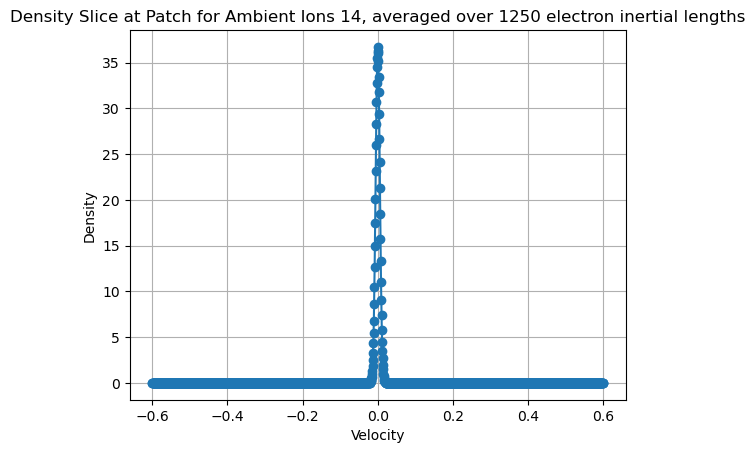

In [42]:
#try to get fv stored in a 2 d array 
#this is for ambient ions

fia = []

for i in range (19):
    slice = histogram_ia[:, i]/1250
    fia.append(slice)

print (fia)
print (len(fia))
# Plot the slice
location = 14
x_edges_for_slice_ia = xedges_ia[:-1]
plt.plot(x_edges_for_slice_ia, fia[location], marker='o')
plt.xlabel('Velocity')
plt.ylabel('Density')
plt.title(f'Density Slice at Patch for Ambient Ions {location}, averaged over 1250 electron inertial lengths')
plt.grid(True)
plt.show()

[array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.])]
19


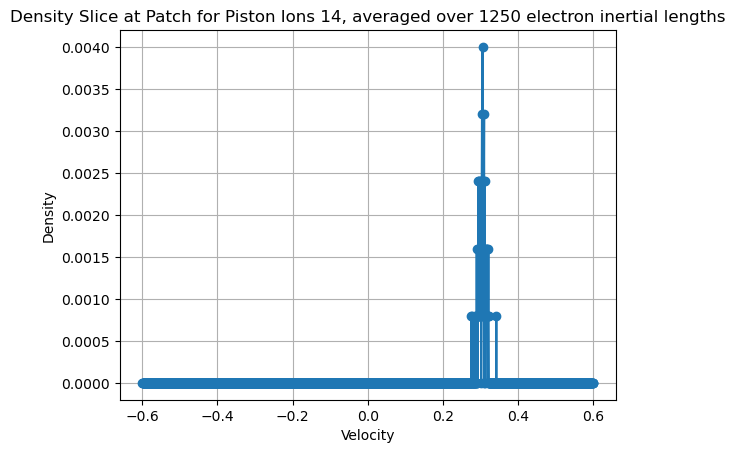

In [43]:
#try to get fv stored in a 2 d array 
#this is for piston ions

fip = []

for i in range (19):
    slice = histogram_ip[:, i]/1250
    fip.append(slice)

print (fip)
print (len(fip))
# Plot the slice
location = 14
x_edges_for_slice_ip = xedges_ip[:-1]
plt.plot(x_edges_for_slice_ip, fip[location], marker='o')
plt.xlabel('Velocity')
plt.ylabel('Density')
plt.title(f'Density Slice at Patch for Piston Ions {location}, averaged over 1250 electron inertial lengths')
plt.grid(True)
plt.show()

[array([0.0008, 0.    , 0.    , ..., 0.    , 0.    , 0.    ]), array([0.0008, 0.    , 0.0008, ..., 0.    , 0.    , 0.    ]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0.0016, 0.    , 0.0008, ..., 0.0016, 0.0032, 0.004 ]), array([0.    , 0.0008, 0.0008, ..., 0.004 , 0.0096, 0.0064]), array([0.    , 0.    , 0.0032, ..., 0.0152, 0.0144, 0.012 ]), array([0.0008, 0.    , 0.    , ..., 0.004 , 0.0032, 0.004 ]), array([0.    , 0.    , 0.    , ..., 0.0008, 0.0008, 0.0008]), array([0.    , 0.0008, 0.    , ..., 0.    , 0.0008, 0.0008]), array([0.    , 0.    , 0.    , ..., 0.0008, 0.    , 0.0016]), array([0.    , 0.    , 0.    , ..., 0.    , 0.0008, 0.    ]), array([0.0008, 0.0008, 0.    , ..., 0.    , 0.0008, 0.0008]), array([0.    , 0.0008, 0.    , ..., 0.0008, 0.    , 0.    ]), array([0.0016, 0.    , 0.    , ..., 0.    , 0.0008, 0.    ]), array([0., 0., 0., ..., 0., 0., 0.]), array([0.    , 0.    , 0.    , ..., 0.    , 0.0008, 0.    ]), array([0.    , 0.

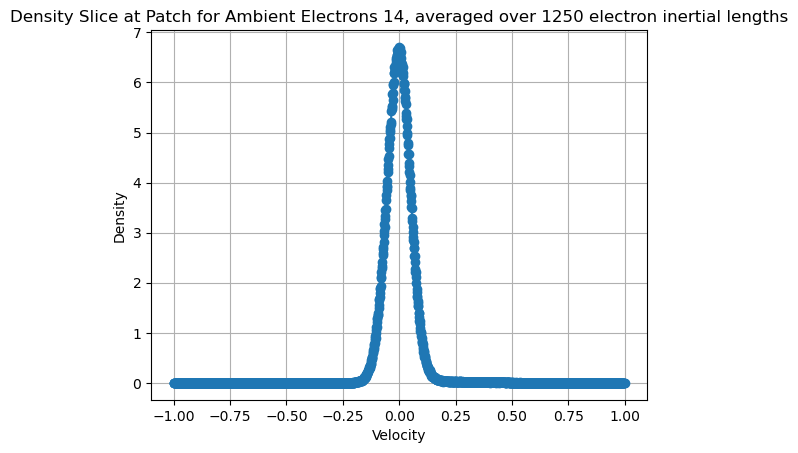

In [44]:
#try to get fv stored in a 2 d array 
#this is for ambient electrons

fea = []

for i in range (19):
    slice = histogram_ea[:, i]/1250
    fea.append(slice)

print (fea)
print (len(fea))
# Plot the slice
location = 14
x_edges_for_slice_ea = xedges_ea[:-1]
plt.plot(x_edges_for_slice_ea, fea[location], marker='o')
plt.xlabel('Velocity')
plt.ylabel('Density')
plt.title(f'Density Slice at Patch for Ambient Electrons {location}, averaged over 1250 electron inertial lengths')
plt.grid(True)
plt.show()

[array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0.    , 0.0008, 0.    , ..., 0.0016, 0.    , 0.0008]), array([0.    , 0.0008, 0.    , ..., 0.0032, 0.0016, 0.0016]), array([0.0008, 0.    , 0.    , ..., 0.0016, 0.0024, 0.0024]), array([0.    , 0.    , 0.0008, ..., 0.    , 0.    , 0.    ]), array([0., 0., 0., ..., 0., 0., 0.]), array([0.    , 0.0008, 0.0008, ..., 0.0008, 0.    , 0.    ]), array([0.0008, 0.0008, 0.    , ..., 0.    , 0.    , 0.    ]), array([0.0008, 0.0008, 0.    , ..., 0.    , 0.    , 0.    ]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0.    , 0.0016, 0.    , ..., 0.0008, 0.    , 0.0008]), array([0.    , 0.0008, 0.0008, ..., 0.    , 0.    , 0.    ]), array([0., 0., 0., ..., 0., 0., 0.]), array([0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.0008])]
19


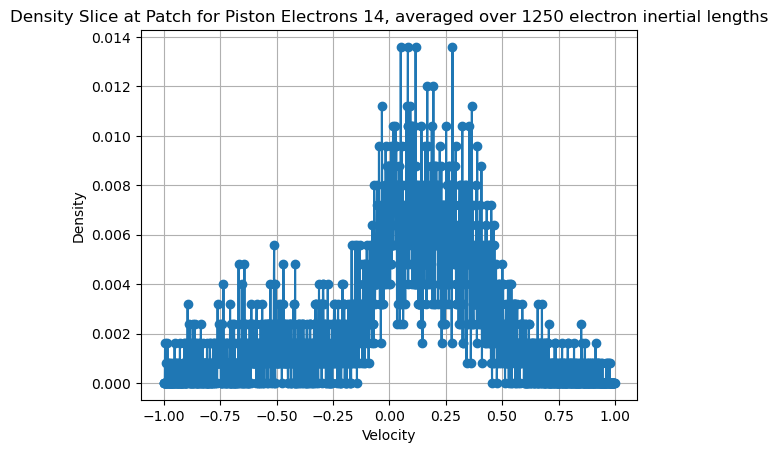

In [45]:
#try to get fv stored in a 2 d array 
#this is for piston electrons

fep = []

for i in range (19):
    slice = histogram_ep[:, i]/1250
    fep.append(slice)

print (fep)
print (len(fep))
# Plot the slice
location = 14
x_edges_for_slice_ep = xedges_ep[:-1]
plt.plot(x_edges_for_slice_ep, fep[location], marker='o')
plt.xlabel('Velocity')
plt.ylabel('Density')
plt.title(f'Density Slice at Patch for Piston Electrons {location}, averaged over 1250 electron inertial lengths')
plt.grid(True)
plt.show()

In [59]:
def gaussian(x, a, mu, sigma):
    return a * np.exp(-((x - mu)**2) / (2 * sigma**2))

In [60]:
#combine fe and fi
fe = [a + b for a, b in zip(fea, fep)]
fi = [a + b for a, b in zip(fia, fip)]

# Normalize every slice in fe
normalized_fe = []
for i in fe:
    integral = np.trapz(i)
    normalized_slice = i / integral if integral != 0 else i
    normalized_fe.append(normalized_slice)

# Normalize every slice in fi
normalized_fi = []
for j in fi:
    integral = np.trapz(j)
    normalized_slice = j / integral if integral != 0 else j
    normalized_fi.append(normalized_slice)



In [ ]:
# Initial guess for the parameters a, mu, sigma
initial_guess = [10, 0, 2]

# Fit the curve
popt, pcov = curve_fit(gaussian, x_data, y_data, p0=initial_guess)

# Plot the data and the fit
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_data, gaussian(x_data, *popt), color='red', label='Fitted Gaussian')
plt.legend()
plt.show()

# Print the parameters
print("Fitted parameters: a =", popt[0], ", mu =", popt[1], ", sigma =", popt[2])

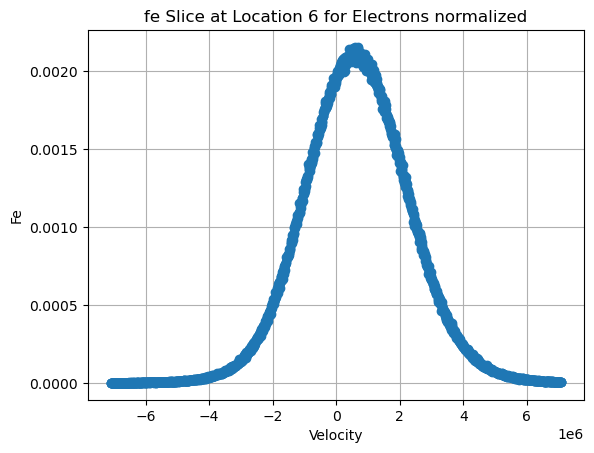

In [47]:
#plot fe
# Plot the slice
location = 6
x_edges_for_slice_e = 7.1e6*xedges_ep[:-1]
plt.plot(x_edges_for_slice_e, normalized_fe[location], marker='o')
plt.xlabel('Velocity')
plt.ylabel('Fe')
plt.title(f'fe Slice at Location {location} for Electrons normalized')
plt.grid(True)
plt.show()

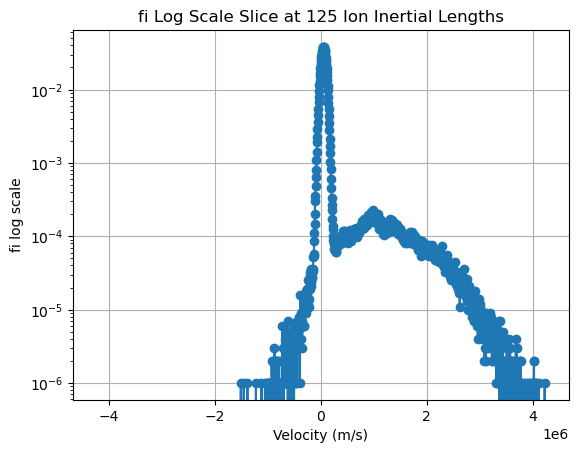

In [48]:
#plot fi
# Plot the slice
# Apply scaling to x-axis values

location = 8

x_edges_for_slice_i = 7.1e6 * xedges_ip[:-1]

# Plot the slice
plt.plot(x_edges_for_slice_i, normalized_fi[location], marker='o')

# Set labels and title
plt.xlabel('Velocity (m/s)')
plt.ylabel('fi log scale')
plt.title(f'fi Log Scale Slice at {int(location*50 * 25 / 10 / 8)} Ion Inertial Lengths')

# Set y-axis to logarithmic scale
plt.yscale('log')

# Add grid and show plot
plt.grid(True)
plt.show()

(54400,)


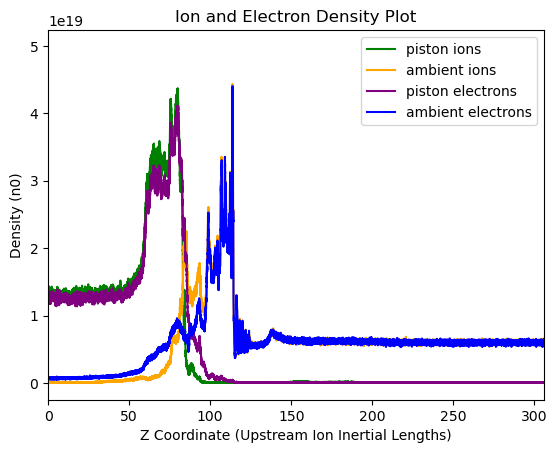

(54400,)
(54400,)


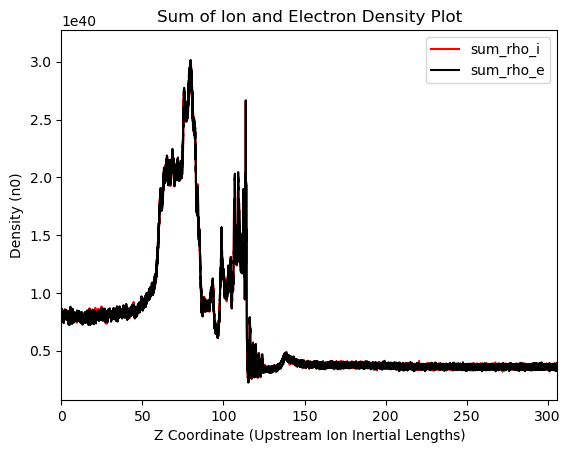

In [49]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Jun 25 15:00:00 2024

@author: Yan
"""
import h5py
import matplotlib.pyplot as plt
import numpy as np

# You need these parameters for conversion. Do not change
nn = 32 * 32
npc = 2000
#################

filename = "smaller_fields.h5"

# z, x, y are coordinates
# E for electric field
# B for magnetic field
# j for current density

with h5py.File(filename, "r") as hf:
    z = hf['z'][()]
print(z.shape)
# rho = number density
# i = ion
# e = electron 
# tar = piston plasma
# am = ambient plasma
# Tss = momentum-velocity tensor
# j = current density
# p = momentum density

# z coordinate conversion
# each grid point is 0.3 de0, upstream density is 0.01, mi/me =64
z = z * 0.3 / 10 / 8

filename2 = "smaller_moments.h5"

with h5py.File(filename2, "r") as hf2:
    rho_i_tar = hf2['rho_i_tar'][()]
    rho_i_am = hf2['rho_i_am'][()]
    rho_e_tar = -1 * hf2['rho_e_tar'][()]
    rho_e_am = -1 * hf2['rho_e_am'][()]

fig, ax = plt.subplots()

mean_rho_i_tar = np.mean(rho_i_tar, axis=1) * 6e20
mean_rho_i_am = np.mean(rho_i_am, axis=1) * 6e20
mean_rho_e_tar = np.mean(rho_e_tar, axis=1) * 6e20
mean_rho_e_am = np.mean(rho_e_am, axis=1) * 6e20

ax.plot(z, mean_rho_i_tar, color='green', label='piston ions')
ax.plot(z, mean_rho_i_am, color='orange', label='ambient ions')
ax.plot(z, mean_rho_e_tar, color='purple', label='piston electrons')
ax.plot(z, mean_rho_e_am, color='blue', label='ambient electrons')

plt.xlim(0, 81600 * 0.3 / 10 / 8)

# Add labels and title
ax.set_xlabel('Z Coordinate (Upstream Ion Inertial Lengths)')
ax.set_ylabel('Density (n0)')
ax.set_title('Ion and Electron Density Plot')
ax.legend()

# Show the plot
plt.show()

# 2nd to see if the e density matches i density
# what target material did combination use Peera, if it was hydrogen, 
# add green and orange add, and add purple and blue line, to see if they overlap everywhere
# constant and overlap
# density units? not yet, units fraction of the target density, 
# Z coordinate

fig, ax2 = plt.subplots()

sum_rho_i = (mean_rho_i_am + mean_rho_i_tar) * 6e20
sum_rho_e = (mean_rho_e_am + mean_rho_e_tar) * 6e20
ax2.plot(z, sum_rho_i, color='red', label='sum_rho_i')
ax2.plot(z, sum_rho_e, color='black', label='sum_rho_e')
plt.xlim(0, 81600 * 0.3 / 10 / 8)
ax2.set_xlabel('Z Coordinate (Upstream Ion Inertial Lengths)')
ax2.set_ylabel('Density (n0)')
ax2.set_title('Sum of Ion and Electron Density Plot')
ax2.legend()

print(sum_rho_e.shape)
print(sum_rho_i.shape)


(27200,)
z every 1250 electron inertial lengths
[3.60000014e-05 7.56000023e-04 1.47600002e-03 ... 1.95818756e+01
 1.95825956e+01 1.95833156e+01]
(27200,)
(27200,)
1431
[4.76846942e+60 4.81089075e+60 4.99418021e+60 7.48931568e+60
 1.37022742e+61 7.50919067e+60 7.42695187e+60 2.99616157e+60
 2.35554933e+60 2.29249075e+60 2.25080928e+60 2.23792305e+60
 2.20774683e+60 2.17001310e+60 2.16199314e+60 2.15883205e+60
 2.15910682e+60 2.15842724e+60 2.16107951e+60]
[4.76806667e+60 4.81251970e+60 4.99468448e+60 7.49103295e+60
 1.37059314e+61 7.50000036e+60 7.42882206e+60 2.99767501e+60
 2.35588806e+60 2.29318019e+60 2.24784583e+60 2.24371589e+60
 2.20356252e+60 2.17327117e+60 2.15866477e+60 2.15834853e+60
 2.15995593e+60 2.16180878e+60 2.16203754e+60]


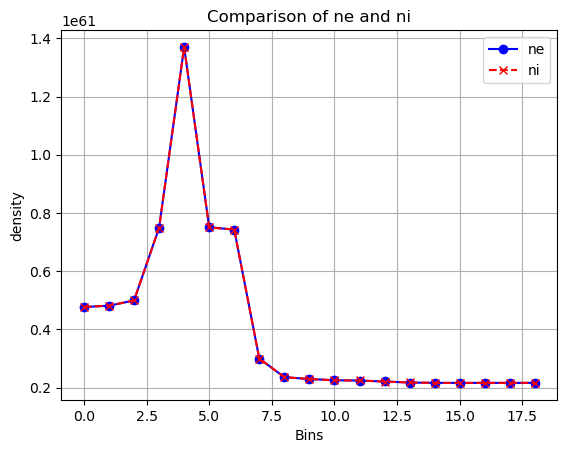

In [50]:
# Constants
factor = 10 * 8 / 50 / 25
start_index = 27200
bin_count = 19

# Slice and scale the data
z_sliced = z[start_index:] * factor
sum_rho_e_sliced = sum_rho_e[start_index:] 
sum_rho_i_sliced = sum_rho_i[start_index:] 

# Print shapes for verification
print(z_sliced.shape)
print("z every 1250 electron inertial lengths")
print(z_sliced)
print(sum_rho_e_sliced.shape)
print(sum_rho_i_sliced.shape)

# Determine the length of each bin
bin_size = len(sum_rho_e_sliced) // bin_count
print (bin_size)

# Reshape and compute mean for each bin
ne = 6e20*np.mean(sum_rho_e_sliced[:bin_count * bin_size].reshape(-1, bin_size), axis=1)
ni = 6e20*np.mean(sum_rho_i_sliced[:bin_count * bin_size].reshape(-1, bin_size), axis=1)

# Print results
print(ne)
print(ni)

bins = np.arange(19)

# Plot ne and ni on the same graph
plt.plot(bins, ne, marker='o', linestyle='-', color='b', label='ne')
plt.plot(bins, ni, marker='x', linestyle='--', color='r', label='ni')

# Customize the plot
plt.xlabel('Bins')
plt.ylabel('density')
plt.title('Comparison of ne and ni')
plt.legend()  # Add a legend to differentiate the lines
plt.grid(True)  # Add a grid for better readability

# Display the plot
plt.show()

In [51]:
%matplotlib inline

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import warnings

from lmfit import Parameters
from plasmapy.diagnostics import thomson

from plasmapy.formulary import Maxwellian_1D
import matplotlib.pyplot as plt
import astropy.constants as const

from scipy.special import expit, gamma
from tqdm import tqdm

import h5py

In [52]:
probe_wavelength = 527 * u.nm

epw_wavelengths = np.linspace(probe_wavelength.value - 20, probe_wavelength.value + 20, num = 200) * u.nm
iaw_wavelengths = np.linspace(probe_wavelength.value - 3, probe_wavelength.value + 3, num = 200) * u.nm

ve = x_edges_for_slice_e
vH = x_edges_for_slice_i

notch = np.array([525, 529])

slice_number = 14

In [53]:
alpha, epw_Pw_arbdist = thomson.spectral_density_arbdist(
    wavelengths = epw_wavelengths,
    notches = [notch] * u.nm,
    probe_wavelength = probe_wavelength,
    e_velocity_axes = [ve] * u.m / u.s,
    i_velocity_axes = [vH] * u.m / u.s,
    efn = [normalized_fe[slice_number]] * u.s / u.m,
    ifn = [normalized_fi[slice_number]] * u.s / u.m,
    n = ne[slice_number] * u.cm ** -3, # Density
    scattered_power = True,
    ion_species = ['p']
)


print(ve.shape)
print()
print(epw_Pw_arbdist.shape)
print(alpha)

(1700,)

(200,)
nan


In [54]:
alpha, iaw_Pw_in = thomson.spectral_density_arbdist(
    wavelengths = iaw_wavelengths,
    probe_wavelength = probe_wavelength,
    e_velocity_axes = [ve] * u.m / u.s,
    i_velocity_axes = [vH] * u.m / u.s,
    efn = [normalized_fe[slice_number]] * u.s / u.m,
    ifn = [normalized_fi[slice_number]] * u.s / u.m,
    n = ni[slice_number] * u.cm ** -3,
    scattered_power = True,
    ion_species = ['p']
)

(200,)
(200,)
507.0 nm


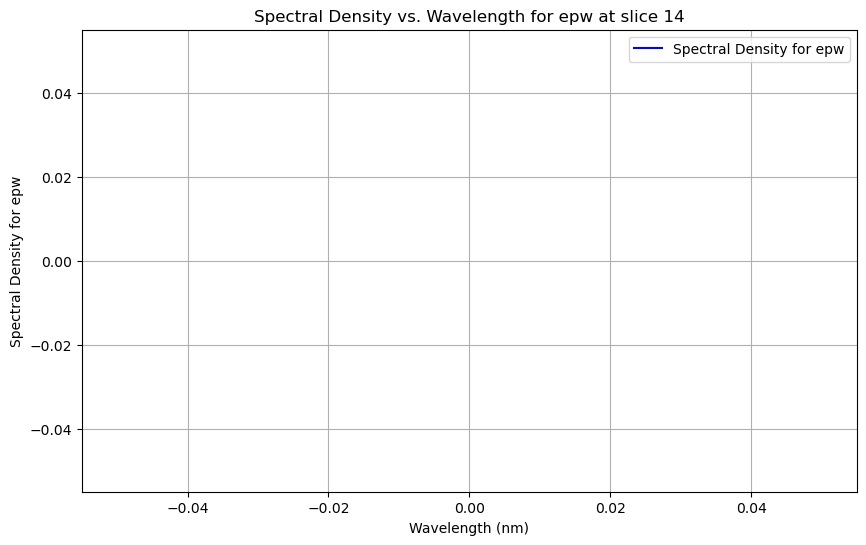

In [55]:
#plotting time!
#plot epw

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epw_wavelengths, (epw_Pw_arbdist), label='Spectral Density for epw', color='b')

print(epw_Pw_arbdist.shape)
print(epw_wavelengths.shape)
print(epw_wavelengths[0])
# Adding labels and title
plt.xlabel('Wavelength (nm)')
plt.ylabel('Spectral Density for epw')
plt.title('Spectral Density vs. Wavelength for epw at slice 14')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

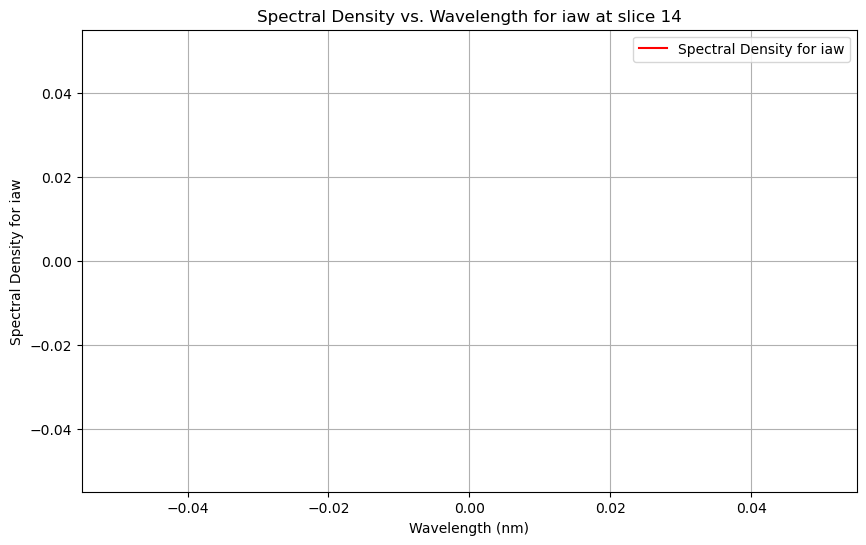

In [56]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(iaw_wavelengths, iaw_Pw_in, label='Spectral Density for iaw', color='r')

# Adding labels and title
plt.xlabel('Wavelength (nm)')
plt.ylabel('Spectral Density for iaw')
plt.title('Spectral Density vs. Wavelength for iaw at slice 14')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

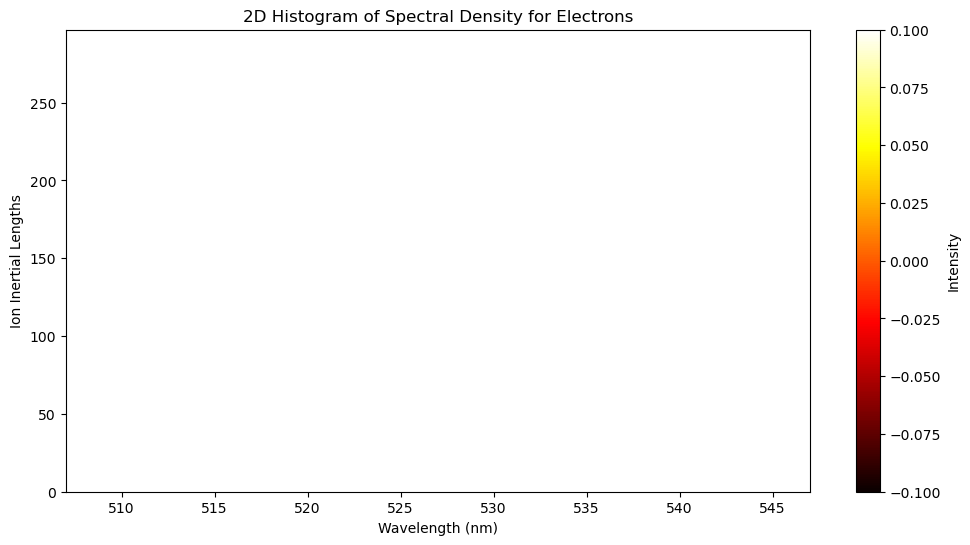

In [57]:
# List to store 1D histograms
array_1d_list = []

# Assuming the number of bins and range are defined
bins = 200
range_min, range_max = (probe_wavelength - 20 * u.nm).value, (probe_wavelength + 20 * u.nm).value

# Loop to calculate and store histograms
for i in range(19):
    alpha, epw_Pw_arbdist1 = thomson.spectral_density_arbdist(
        wavelengths=epw_wavelengths.to(u.nm),  # Ensure epw_wavelengths is in nanometers
        notches=[notch] * u.nm,
        probe_wavelength=probe_wavelength,
        e_velocity_axes=[ve] * u.m / u.s,
        i_velocity_axes=[vH] * u.m / u.s,
        efn=[normalized_fe[i]] * u.s / u.m,
        ifn=[normalized_fi[i]] * u.s / u.m,
        n=ne[i] * u.cm ** -3,  # Density
        scattered_power=True,
        ion_species=['p']
    )
    
    # Compute the 1D histogram
    hist1d, bin_edges = np.histogram(epw_wavelengths.value, bins=bins, range=(range_min, range_max), weights=epw_Pw_arbdist1)
    
    # Append histogram to list
    array_1d_list.append(hist1d)

# Convert the list of 1D histograms into a 2D array
array_2d = np.array(array_1d_list)

# Define the factor to multiply the y-axis
factor = 50 * 25 / 10 / 8

# Optional: Plotting the 2D histogram with the 'hot' color scheme and adjusted y-axis
plt.figure(figsize=(12, 6))
plt.imshow(array_2d, aspect='auto', extent=[range_min, range_max, 0, 19 * factor], origin='lower', cmap='hot')
plt.colorbar(label='Intensity')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Ion Inertial Lengths')
plt.title('2D Histogram of Spectral Density for Electrons')
plt.show()




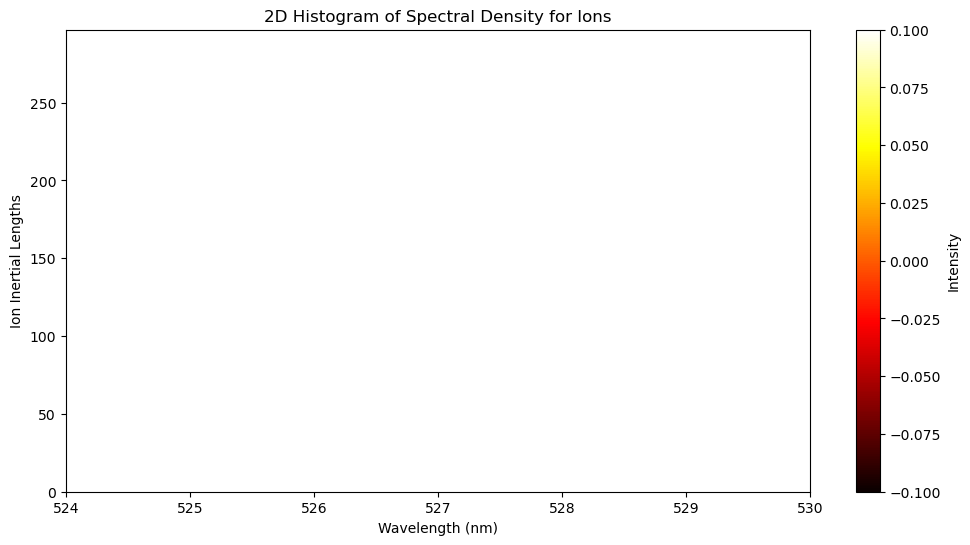

In [58]:
# List to store 1D histograms
array_1d_list1 = []

# Assuming the number of bins and range are defined
bins = 200
range_min, range_max = (probe_wavelength - 3 * u.nm).value, (probe_wavelength + 3 * u.nm).value

# Loop to calculate and store histograms
for i in range(19):
    alpha, iaw_Pw_in = thomson.spectral_density_arbdist(
    wavelengths = iaw_wavelengths,
    probe_wavelength = probe_wavelength,
    e_velocity_axes = [ve] * u.m / u.s,
    i_velocity_axes = [vH] * u.m / u.s,
    efn = [normalized_fe[i]] * u.s / u.m,
    ifn = [normalized_fi[i]] * u.s / u.m,
    n = ni[i] * u.cm ** -3,
    scattered_power = True,
    ion_species = ['p']
)
    
    # Compute the 1D histogram
    hist1d, bin_edges = np.histogram(iaw_wavelengths.value, bins=bins, range=(range_min, range_max), weights=iaw_Pw_in)
    
    # Append histogram to list
    array_1d_list1.append(hist1d)

# Convert the list of 1D histograms into a 2D array
array_2d = np.array(array_1d_list1)

# Define the factor to multiply the y-axis
factor = 50 * 25 / 10 / 8

# Optional: Plotting the 2D histogram
plt.figure(figsize=(12, 6))
plt.imshow(array_2d, aspect='auto', extent=[range_min, range_max, 0, 19 * factor], origin='lower', cmap='hot')
plt.colorbar(label='Intensity')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Ion Inertial Lengths')
plt.title('2D Histogram of Spectral Density for Ions')
plt.show()
